# 4.3 파이토치로 MNIST 이미지 분류 구현하기

In [8]:
import torch
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

# 숫자 손글씨 이미지 데이터 집합 MNIST 다운로드
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
# mnist = fetch_openml('mnist_784', version=1, cache=True)
# mnist
# data_home에 내려받은 경로를 지정

### 1. 데이터 전처리

이미지 데이터의 레이블은 0이다.


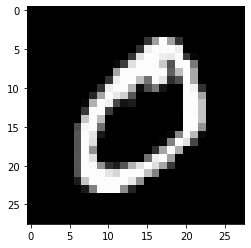

In [10]:
# 이미지 데이터와 레이블 데이터 분리, 정규화
X = mnist.data / 255 # 0~255값을 [0,1] 구간으로 정규화
y = mnist.target

# 첫 번째 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[0].reshape(28,28), cmap='gray')
print("이미지 데이터의 레이블은 {:.0f}이다.".format(y[0]))

### 2. DataLoader로 변환
정규화를 마친 데이터를 파이토치 신경망에서 다룰 수 있게 DataLoader 객체로 변환한다.

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 데이터를 훈련 데이터와 테스트 데이터로 분할(6:1 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

# 2.2 데이터를 파이토치 텐서로 변환
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 데이터와 정답 레이블을 하나로 묶어 Dataset으로 만듬
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 미니배치 크기를 지정해 DataLoader 객체로 변환
# Chainer의 iterators.SerialIterator와 비슷함
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

### 3. 신경망 구성
Keras 스타일

In [12]:
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


### 4. 오차함수 및 최적화 기법 설정

In [32]:
from torch import optim

# 오차함수 선택
loss_fn = nn.CrossEntropyLoss() # criterion을 변수명으로 사용하는 경우가 많다.

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01) # lr = 학습률

### 5. 학습 및 추론 설정

In [33]:
# 5-1. 학습 중 1에포크에서 수행할 일을 함수로 정의
# 파이토치에는 Chainer의 training.Trainer()에 해당하는 것이 없음


def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:
      
        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정

    print("epoch{}：완료\n".format(epoch))

In [34]:
# 5-2. 추론 1에포크에서 할 일을 함수로 정의
# 파이토치에는 Chainer의 trainer.extend(extensions.Evaluator())에 해당하는 것이 없음


def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))

### 학습 전 상태에서 테스트 데이터로 정확도 측정

In [35]:
test()


테스트 데이터에서 예측 정확도: 1014/10000 (10%)



### 6. 학습 및 추론 수행

In [36]:
for epoch in range(3):
    train(epoch)

test()

epoch0：완료

epoch1：완료

epoch2：완료


테스트 데이터에서 예측 정확도: 9587/10000 (96%)



### 2018번째 데이터를 예로 추론 수행

예측 결과 : 7
이 이미지 데이터의 정답 레이블은 7입니다


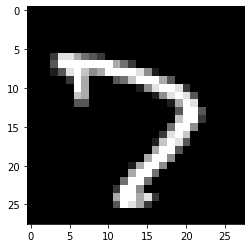

In [37]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))

-----------------------------------------------------

## 파이토치 사용법에 대한 보충 설명

### 3. 신경망 구성
Chainer 스타일

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  # Chainer와 달리、None을 받을 수는 없다
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        # 입력 x에 따라 forward 계산 과정이 변화함
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output


model1 = Net(n_in=28*28*1, n_mid=100, n_out=10)  # 신경망 객체를 생성
print(model1)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
